In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo

In [2]:
# fetch dataset
car = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car.data.features

In [3]:
expanded_cols = []
X_numeric_pd = X.copy()
for col in X.columns:
    X_numeric_pd[col] = X_numeric_pd[col].astype("category").cat.codes

In [4]:
def custom_combiner(feature, category):
    # print(f"feature: {feature}")
    # print(f"category: {category}")
    if feature == "feature":
        return "test"
    feature_og_name_dict = dict(
        enumerate(X[feature].astype("category").cat.categories)
    )
    return f"{feature}={feature_og_name_dict[category]}"


ohe = OneHotEncoder(drop="if_binary", feature_name_combiner=custom_combiner)
X_oh_np = ohe.fit_transform(X_numeric_pd.to_numpy()).toarray()
feature_names = ohe.get_feature_names_out(
    input_features=X_numeric_pd.columns.to_list()
)

print(X_oh_np.shape)
print(feature_names)


# convert categorical target to numerical
le = LabelEncoder()
y_np = le.fit_transform(car.data.targets.to_numpy().flatten())
print(y_np.shape)
print(le.classes_.tolist())

(1728, 21)
['buying=high' 'buying=low' 'buying=med' 'buying=vhigh' 'maint=high'
 'maint=low' 'maint=med' 'maint=vhigh' 'doors=2' 'doors=3' 'doors=4'
 'doors=5more' 'persons=2' 'persons=4' 'persons=more' 'lug_boot=big'
 'lug_boot=med' 'lug_boot=small' 'safety=high' 'safety=low' 'safety=med']
(1728,)
['acc', 'good', 'unacc', 'vgood']


In [5]:
train_X, hold_out_test_X, train_y, hold_out_test_y = train_test_split(
    X_oh_np, y_np, test_size=0.2, random_state=73, stratify=y_np
)

In [6]:
np.bincount(train_y), np.bincount(hold_out_test_y)

(array([307,  55, 968,  52]), array([ 77,  14, 242,  13]))

In [7]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [8]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [9]:
def multiclass_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []

    hold_out_accuracy = []

    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
        model.fit(train_X[train_index], train_y[train_index])

        y_pred = model.predict(train_X[test_index])

        acc = accuracy_score(train_y[test_index], y_pred)
        fold_accuracy.append(acc)

        print(
            classification_report(
                train_y[test_index], y_pred, target_names=le.classes_
            )
        )

        # Test on hold-out test set
        y_hold_out_pred = model.predict(hold_out_test_X)

        acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
        hold_out_accuracy.append(acc)
        print("Hold-out Test")
        print(
            classification_report(
                hold_out_test_y, y_hold_out_pred, target_names=le.classes_
            )
        )

        # Plot confusion matrix
        cm = confusion_matrix(train_y[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")

    print("\nHold-out Test Results:")
    print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 5-fold cross-validation

              precision    recall  f1-score   support

         acc       0.78      0.84      0.81        61
        good       0.57      0.36      0.44        11
       unacc       0.96      0.95      0.95       194
       vgood       0.69      0.82      0.75        11

    accuracy                           0.90       277
   macro avg       0.75      0.74      0.74       277
weighted avg       0.89      0.90      0.89       277

Hold-out Test
              precision    recall  f1-score   support

         acc       0.75      0.82      0.78        77
        good       0.54      0.50      0.52        14
       unacc       0.96      0.94      0.95       242
       vgood       0.92      0.92      0.92        13

    accuracy                           0.89       346
   macro avg       0.79      0.79      0.79       346
weighted avg       0.90      0.89      0.89       346

              precision    recall  f1-score   support

     

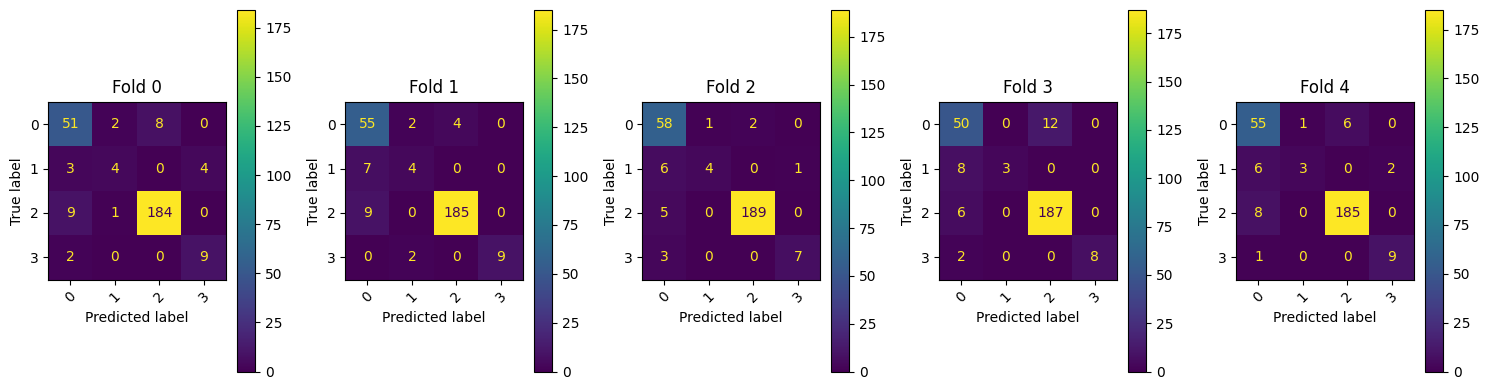

In [10]:
model = LogisticRegression(solver="saga")
multiclass_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 5-fold cross-validation

              precision    recall  f1-score   support

         acc       0.89      0.97      0.93        61
        good       0.86      0.55      0.67        11
       unacc       0.99      0.98      0.99       194
       vgood       0.69      0.82      0.75        11

    accuracy                           0.95       277
   macro avg       0.86      0.83      0.83       277
weighted avg       0.96      0.95      0.95       277

Hold-out Test
              precision    recall  f1-score   support

         acc       0.89      0.92      0.90        77
        good       0.69      0.79      0.73        14
       unacc       0.99      0.97      0.98       242
       vgood       0.92      0.85      0.88        13

    accuracy                           0.95       346
   macro avg       0.87      0.88      0.87       346
weighted avg       0.95      0.95      0.95       346

              precision    recall  f1-score   support

         ac

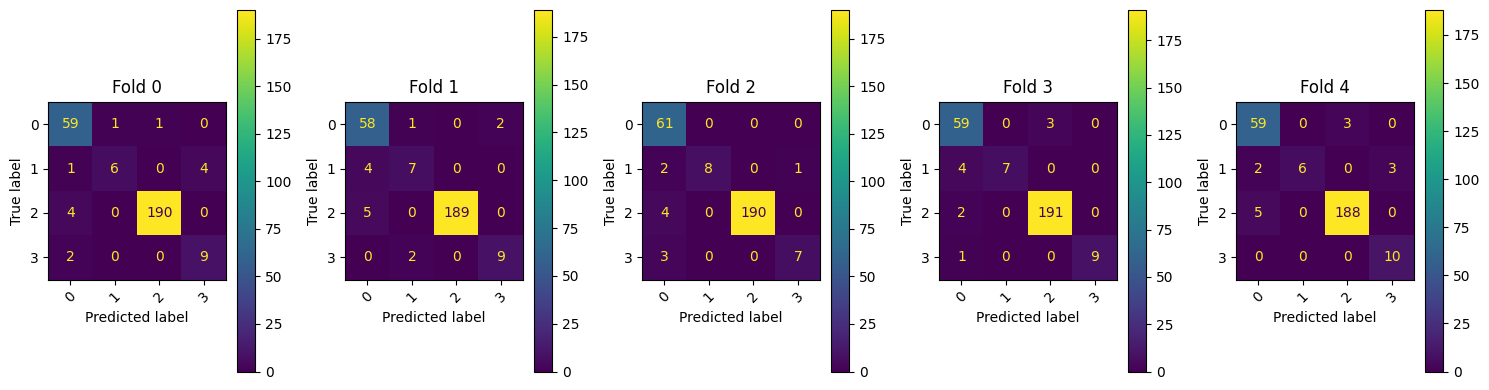

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
multiclass_classification(model, "Random Forest")

## SVM

Model SVM with 5-fold cross-validation

              precision    recall  f1-score   support

         acc       0.79      0.98      0.88        61
        good       0.92      1.00      0.96        11
       unacc       1.00      0.92      0.96       194
       vgood       1.00      1.00      1.00        11

    accuracy                           0.94       277
   macro avg       0.93      0.98      0.95       277
weighted avg       0.95      0.94      0.94       277

Hold-out Test
              precision    recall  f1-score   support

         acc       0.79      0.95      0.86        77
        good       0.68      0.93      0.79        14
       unacc       1.00      0.91      0.95       242
       vgood       0.93      1.00      0.96        13

    accuracy                           0.92       346
   macro avg       0.85      0.95      0.89       346
weighted avg       0.94      0.92      0.93       346

              precision    recall  f1-score   support

         acc       0.

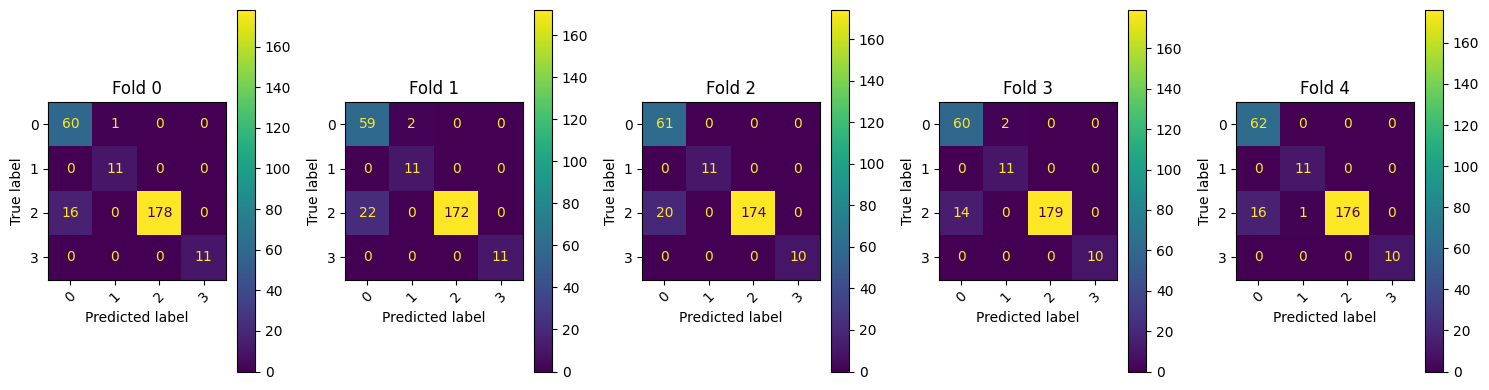

In [12]:
model = SVC(kernel="rbf", random_state=76, class_weight="balanced")
multiclass_classification(model, "SVM")